# LORA

# **LoRA (Low-Rank Adaptation)**

LoRA optimizes fine-tuning by freezing pre-trained weights and updating only a small set of trainable parameters. Instead of updating the full weight matrix \( W \), it tracks low-rank changes \( \Delta W \).

## **Mathematical Explanation**

For a weight matrix $( W_0 $\) (pre-trained), LoRA introduces two low-rank matrices \( A \) and \( B \):

$ [
W = W_0 + \Delta W, \quad \Delta W = A \times B
] $

where:

- \( A \) has dimensions \( (d \times r) \)
- \( B \) has dimensions \( (r \times d) \)
- \( r \) is a small rank value (e.g., 4 or 8).

Instead of updating \( W_0 \), we only train \( A \) and \( B \), reducing the number of parameters.

## **Example Usage**
- **Finance**: Fine-tuning ChatGPT for financial reports.
- **Sales**: Customizing LLaMA-2 for lead generation.


In [12]:
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model, TaskType
from transformers import TrainerCallback
from datasets import load_dataset
import torch

# Load dataset (Example: English Wikipedia dataset)
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train[:1%]")  # Use a small subset for quick testing

# Load model & tokenizer
model_name = "EleutherAI/pythia-70m"  # Small model for quick training
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Set padding token
tokenizer.pad_token = tokenizer.eos_token

# Print model layers to find correct target modules
for name, _ in model.named_parameters():
    print(name)  # Check available layers

# Tokenize dataset
def tokenize_function(examples):
    tokenized_inputs = tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)
    tokenized_inputs["labels"] = tokenized_inputs["input_ids"].copy()  # Add labels
    return tokenized_inputs

dataset = dataset.map(tokenize_function, batched=True)

# LoRA configuration (Choose correct modules based on printed layer names)
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["query_key_value", "dense", "dense_h_to_4h", "dense_4h_to_h"]  # Corrected target modules
)

# Apply LoRA to model
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# Training arguments
training_args = TrainingArguments(
    output_dir="./results_lora",
    per_device_train_batch_size=2,
    num_train_epochs=1,  # Reduce epochs for quick testing
    save_strategy="epoch",
    logging_steps=10,
    report_to="none"
)

# List to store loss values
loss_values_lora= []

# Custom callback to log losses
class LossLoggerCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and "loss" in logs:
            loss_values_lora.append(logs["loss"])
            print(f"Step {state.global_step}: Loss = {logs['loss']}")

    def on_init_end(self, args, state, control, **kwargs):
        print("Training initialized.")

    def on_train_begin(self, args, state, control, **kwargs):
        print("Training started.")

    def on_train_end(self, args, state, control, **kwargs):
        print("Training completed.")
        print("All Loss Values:", loss_values_lora)

# Train with LoRA
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    callbacks=[LossLoggerCallback()]  # Attach custom callback
)

trainer.train()

# Print all stored losses
print("All Loss Values:", loss_values_lora)


gpt_neox.embed_in.weight
gpt_neox.layers.0.input_layernorm.weight
gpt_neox.layers.0.input_layernorm.bias
gpt_neox.layers.0.post_attention_layernorm.weight
gpt_neox.layers.0.post_attention_layernorm.bias
gpt_neox.layers.0.attention.query_key_value.weight
gpt_neox.layers.0.attention.query_key_value.bias
gpt_neox.layers.0.attention.dense.weight
gpt_neox.layers.0.attention.dense.bias
gpt_neox.layers.0.mlp.dense_h_to_4h.weight
gpt_neox.layers.0.mlp.dense_h_to_4h.bias
gpt_neox.layers.0.mlp.dense_4h_to_h.weight
gpt_neox.layers.0.mlp.dense_4h_to_h.bias
gpt_neox.layers.1.input_layernorm.weight
gpt_neox.layers.1.input_layernorm.bias
gpt_neox.layers.1.post_attention_layernorm.weight
gpt_neox.layers.1.post_attention_layernorm.bias
gpt_neox.layers.1.attention.query_key_value.weight
gpt_neox.layers.1.attention.query_key_value.bias
gpt_neox.layers.1.attention.dense.weight
gpt_neox.layers.1.attention.dense.bias
gpt_neox.layers.1.mlp.dense_h_to_4h.weight
gpt_neox.layers.1.mlp.dense_h_to_4h.bias
gpt_neo

Step,Training Loss
10,7.054000
20,5.647000
30,4.742500
40,3.144400
50,1.710700
60,1.897500
70,0.937600
80,1.660700
90,1.209500
100,2.155100


Step 10: Loss = 7.054
Step 20: Loss = 5.647
Step 30: Loss = 4.7425
Step 40: Loss = 3.1444
Step 50: Loss = 1.7107
Step 60: Loss = 1.8975
Step 70: Loss = 0.9376
Step 80: Loss = 1.6607
Step 90: Loss = 1.2095
Step 100: Loss = 2.1551
Step 110: Loss = 0.6513
Step 120: Loss = 0.4979
Step 130: Loss = 1.8877
Step 140: Loss = 1.357
Step 150: Loss = 1.8192
Step 160: Loss = 1.1065
Step 170: Loss = 1.3506
Step 180: Loss = 1.8627
Training completed.
All Loss Values: [7.054, 5.647, 4.7425, 3.1444, 1.7107, 1.8975, 0.9376, 1.6607, 1.2095, 2.1551, 0.6513, 0.4979, 1.8877, 1.357, 1.8192, 1.1065, 1.3506, 1.8627]
All Loss Values: [7.054, 5.647, 4.7425, 3.1444, 1.7107, 1.8975, 0.9376, 1.6607, 1.2095, 2.1551, 0.6513, 0.4979, 1.8877, 1.357, 1.8192, 1.1065, 1.3506, 1.8627]


# Full Finetuning

# **Full Fine-Tuning**

Full fine-tuning updates **all** model weights, allowing the model to learn new patterns comprehensively. It is commonly used when adapting large language models (LLMs) to **domain-specific tasks**.

## **How It Works**
1. **All parameters** of the pre-trained model are updated during training.
2. Requires a large amount of **compute power** and **GPU memory**.
3. Can achieve **optimal adaptation** to the new dataset, but is computationally expensive.

## **Mathematical Explanation**
Let \( \theta_0 \) be the pre-trained model parameters. During fine-tuning, all parameters are updated using **gradient descent**:

$ [
\theta = \theta_0 - \eta \nabla L(\theta)
] $

where:
- $ ( \theta ) $represents the model parameters.
- \$( \eta \)$ is the learning rate.
- \( L(\theta) \) is the loss function.
- \( \nabla L(\theta) \) is the gradient of the loss function with respect to \( \theta \).

## **Advantages**
✅ **Maximum Performance**: Since all weights are updated, the model can fully adapt to new tasks.  
✅ **Better Generalization**: If sufficient data is available, the model learns domain-specific knowledge more effectively.  
✅ **No Extra Layers**: Unlike LoRA or adapters, there are no additional parameters; the entire model is fine-tuned.

## **Disadvantages**
❌ **High Computational Cost**: Requires expensive **GPUs (A100, H100)** or TPUs.  
❌ **Risk of Overfitting**: The model might overfit if the dataset is small.  
❌ **Longer Training Time**: Full fine-tuning can take hours or even days for large models.  

## **Use Cases**
- **Medical AI**: Fine-tuning GPT-4 for **medical diagnosis**.
- **Legal AI**: Training LLaMA-2 on **legal documents** for case law analysis.
- **Finance**: Customizing ChatGPT for **financial market predictions**.





In [9]:
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments, TrainerCallback
from datasets import load_dataset

# Load dataset
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train[:1%]")

# Load model & tokenizer
model_name = "EleutherAI/pythia-70m"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Tokenization
def tokenize_function(examples):
    tokenized_inputs = tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)
    tokenized_inputs["labels"] = tokenized_inputs["input_ids"].copy()
    return tokenized_inputs

dataset = dataset.map(tokenize_function, batched=True)

# Training Arguments
training_args = TrainingArguments(
    output_dir="./results_full_finetuning",
    per_device_train_batch_size=2,
    num_train_epochs=1,
    save_strategy="epoch",
    logging_steps=10,
    report_to="none"
)

# List to store loss values
loss_values = []

# Custom callback to log losses
class LossLoggerCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and "loss" in logs:
            loss_values.append(logs["loss"])
            print(f"Step {state.global_step}: Loss = {logs['loss']}")

    def on_train_end(self, args, state, control, **kwargs):
        print("Training completed.")
        print("All Loss Values:", loss_values)

# Trainer (Full Fine-Tuning)
trainer = Trainer(model=model, args=training_args, train_dataset=dataset, callbacks=[LossLoggerCallback()])
trainer.train()

# Print all stored losses
print("All Loss Values:", loss_values)

Step,Training Loss
10,2.719300
20,1.995400
30,1.537900
40,1.656200
50,1.388800
60,2.014000
70,0.830100
80,1.855300
90,1.171100
100,2.380500


Step 10: Loss = 2.7193
Step 20: Loss = 1.9954
Step 30: Loss = 1.5379
Step 40: Loss = 1.6562
Step 50: Loss = 1.3888
Step 60: Loss = 2.014
Step 70: Loss = 0.8301
Step 80: Loss = 1.8553
Step 90: Loss = 1.1711
Step 100: Loss = 2.3805
Step 110: Loss = 0.5511
Step 120: Loss = 0.4556
Step 130: Loss = 1.9094
Step 140: Loss = 1.3223
Step 150: Loss = 1.821
Step 160: Loss = 0.992
Step 170: Loss = 1.2007
Step 180: Loss = 1.7499
Training completed.
All Loss Values: [2.7193, 1.9954, 1.5379, 1.6562, 1.3888, 2.014, 0.8301, 1.8553, 1.1711, 2.3805, 0.5511, 0.4556, 1.9094, 1.3223, 1.821, 0.992, 1.2007, 1.7499]
All Loss Values: [2.7193, 1.9954, 1.5379, 1.6562, 1.3888, 2.014, 0.8301, 1.8553, 1.1711, 2.3805, 0.5511, 0.4556, 1.9094, 1.3223, 1.821, 0.992, 1.2007, 1.7499]


# No Tuning

In [10]:
import torch

# Disable gradient computation (inference mode)
model.eval()

# Compute loss on a few samples
losses = []
for batch in dataset.shuffle(seed=42).select(range(50)):  # Use 50 examples
    inputs = tokenizer(batch["text"], return_tensors="pt", padding="max_length", truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
    loss = outputs.loss.item()
    losses.append(loss)

print(f"Average Loss Without Fine-Tuning: {sum(losses) / len(losses)}")


Average Loss Without Fine-Tuning: 0.7234824946254957


# Comparision of Losses

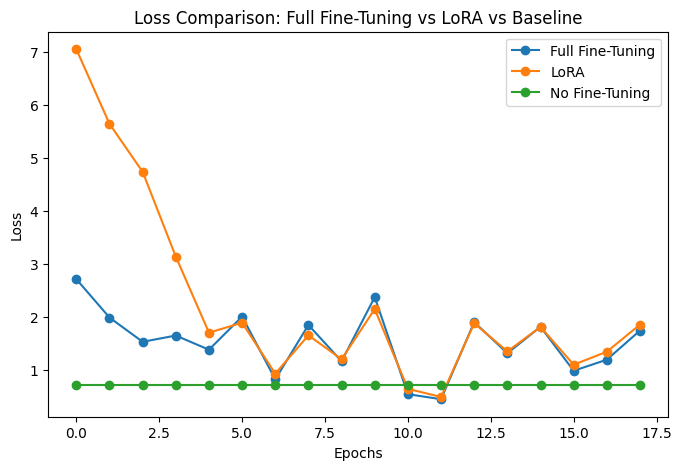

In [12]:
import matplotlib.pyplot as plt

# Example Losses (Replace with actual values from your logs)
losses = {
    "Full Fine-Tuning": [2.7193, 1.9954, 1.5379, 1.6562, 1.3888, 2.014, 0.8301, 1.8553, 1.1711, 2.3805, 0.5511, 0.4556, 1.9094, 1.3223, 1.821, 0.992, 1.2007, 1.7499],
    "LoRA": [7.054, 5.647, 4.7425, 3.1444, 1.7107, 1.8975, 0.9376, 1.6607, 1.2095, 2.1551, 0.6513, 0.4979, 1.8877, 1.357, 1.8192, 1.1065, 1.3506, 1.8627],
    "No Fine-Tuning": [0.72] * 18  # Constant loss (since no training)
}

# Plot
plt.figure(figsize=(8, 5))
for label, loss in losses.items():
    plt.plot(loss, label=label, marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Comparison: Full Fine-Tuning vs LoRA vs Baseline")
plt.legend()
plt.show()


### **Comparison with Other Fine-Tuning Techniques**

| Method           | Updated Parameters | Compute Cost | Use Case |
|----------------|----------------|--------------|-----------|
| **Full Fine-Tuning** | All | High | Best for high-budget projects |
| **LoRA** | Low-rank matrices (A, B) | Low | Efficient fine-tuning with less compute |
| **Adapters** | Additional adapter layers | Moderate | Reusable tuning for multiple tasks |

---

### **Conclusion**
Full fine-tuning is **powerful** but **resource-intensive**. It is best suited for large-scale applications with **ample computational resources**. For cost-efficient fine-tuning, techniques like **LoRA** or **adapter-based tuning** may be better alternatives.
